In [1]:
# from google.colab import drive
# drive.mount('/content/drive/')
# %cd drive/MyDrive/resnet_miniproject/

Mounted at /content/drive/
/content/drive/MyDrive/resnet_miniproject


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as data

from model import ResidualBlock, ResNet
from train_eval_util import train, evaluate, calculate_accuracy, epoch_time, total_layers, total_params
from dataset import train_data, valid_data, test_data

import time
import numpy as np 

import matplotlib.pyplot as plt

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')  
else:
    device = torch.device('cpu')

print(f"Selected device: {device}")

Selected device: cuda


# Dataloader and batch size

In [4]:
BATCH_SIZE = 32

train_iterator = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
valid_iterator =  DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)
test_iterator =  DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

# Setting up models

In [5]:
model_1 = ResNet(ResidualBlock, [1, 1, 1]).to(device)
model_2 = ResNet(ResidualBlock, [5, 5, 5]).to(device)
model_3 = ResNet(ResidualBlock, [18, 18, 18]).to(device)

models = [model_1, model_2, model_3 ]

for i in models:
  print(f'ResNet {total_layers(i)}, with {total_params(i)} Parameters')

from torchsummary import summary
summary(model_2, (3, 32,32))


ResNet 8, with 78042 Parameters
ResNet 32, with 466906 Parameters
ResNet 110, with 1730714 Parameters
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 16, 32, 32]           2,304
       BatchNorm2d-4           [-1, 16, 32, 32]              32
            Conv2d-5           [-1, 16, 32, 32]           2,304
       BatchNorm2d-6           [-1, 16, 32, 32]              32
     ResidualBlock-7           [-1, 16, 32, 32]               0
            Conv2d-8           [-1, 16, 32, 32]           2,304
       BatchNorm2d-9           [-1, 16, 32, 32]              32
           Conv2d-10           [-1, 16, 32, 32]           2,304
      BatchNorm2d-11           [-1, 16, 32, 32]              32
    ResidualBlock-12           [-1, 16, 32, 32]               0
 

# Training

In [6]:
num_epochs = 10
num_models = len(models)

T_loss_hist = np.zeros(( num_models, num_epochs))
T_acc_hist = np.zeros(( num_models, num_epochs))

V_loss_hist = np.zeros(( num_models, num_epochs))
V_acc_hist = np.zeros(( num_models, num_epochs))

trained_models = []

for m in range(num_models):

  model = models[m]
  print(f'ResNet {total_layers(model)} --------------------------------------------------')

  criterion = nn.CrossEntropyLoss().to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 0.0001)
  # optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

  train_acc_history = []
  train_loss_history = []
  valid_acc_history = []
  valid_loss_history = []
  lr_epoch = []


  for epoch in range(num_epochs):

    start_time = time.time()
    
   
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    
    scheduler.step()
    lr_now = lr_now = optimizer.param_groups[0]['lr']
    lr_epoch.append(lr_now)

    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    end_time = time.time()

        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | LR: {lr_now:.6f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    

    train_acc_history.append(train_acc)
    train_loss_history.append(train_loss)
    valid_acc_history.append(valid_acc)
    valid_loss_history.append(valid_loss)

  T_loss_hist[m] = train_loss_history
  T_acc_hist[m] = train_acc_history

  V_loss_hist[m] = valid_loss_history
  V_acc_hist[m] = valid_acc_history

  # torch.save(model, 'model_'+ str(m) +'.pth')


ResNet 8 --------------------------------------------------
Epoch: 01 | Epoch Time: 0m 31s
	Train Loss: 1.461 | Train Acc: 46.43% | LR: 0.000976
	 Val. Loss: 1.178 |  Val. Acc: 57.52%
Epoch: 02 | Epoch Time: 0m 30s
	Train Loss: 1.087 | Train Acc: 61.42% | LR: 0.000905
	 Val. Loss: 0.950 |  Val. Acc: 66.24%
Epoch: 03 | Epoch Time: 0m 30s
	Train Loss: 0.954 | Train Acc: 66.43% | LR: 0.000794
	 Val. Loss: 0.966 |  Val. Acc: 65.01%
Epoch: 04 | Epoch Time: 0m 29s
	Train Loss: 0.874 | Train Acc: 69.19% | LR: 0.000655
	 Val. Loss: 0.903 |  Val. Acc: 68.05%
Epoch: 05 | Epoch Time: 0m 29s
	Train Loss: 0.816 | Train Acc: 71.32% | LR: 0.000500
	 Val. Loss: 0.762 |  Val. Acc: 73.43%
Epoch: 06 | Epoch Time: 0m 29s
	Train Loss: 0.758 | Train Acc: 73.60% | LR: 0.000345
	 Val. Loss: 0.714 |  Val. Acc: 74.28%
Epoch: 07 | Epoch Time: 0m 30s
	Train Loss: 0.712 | Train Acc: 75.05% | LR: 0.000206
	 Val. Loss: 0.662 |  Val. Acc: 76.71%
Epoch: 08 | Epoch Time: 0m 29s
	Train Loss: 0.679 | Train Acc: 76.47% | 

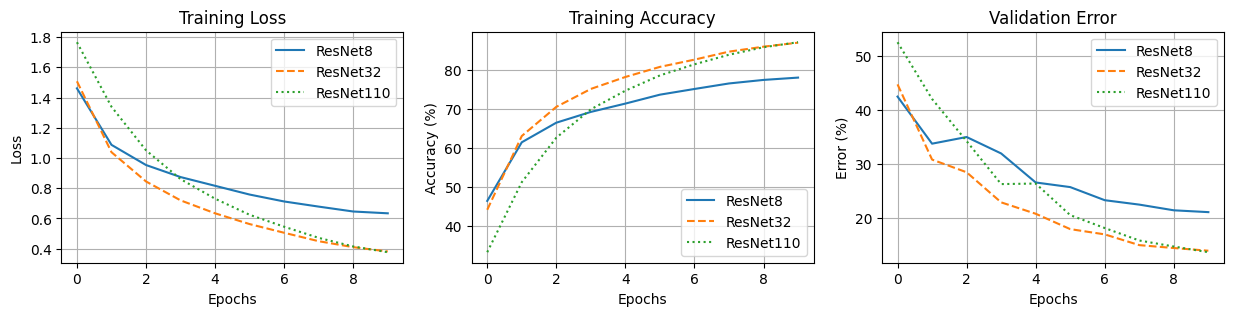

In [24]:
fig,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
dashes = ['-', '--', ':', '-.']
model_names = [ ]

for i in models:
  model_names.append('ResNet'+str(total_layers(i)))


for m in range(num_models):
  ax1.plot(range(num_epochs), T_loss_hist[m], dashes[m])
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Training Loss')
  ax1.grid()
  ax1.legend(model_names)

  ax2.plot(range(num_epochs), T_acc_hist[m]*100, dashes[m])
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy (%)')
  ax2.set_title('Training Accuracy')
  ax2.grid()
  ax2.legend(model_names)

  ax3.plot(range(num_epochs), (1-V_acc_hist[m])*100, dashes[m])
  ax3.set_xlabel('Epochs')
  ax3.set_ylabel('Error (%)')
  ax3.set_title('Validation Error')
  ax3.grid()
  ax3.legend(model_names)